### An examples of how to explain models trained by HyperGBM

We use cross validation to split the data and train the model, since that we can choose model of any fold to interpret.

In [1]:
import shap

from sklearn.model_selection import train_test_split

from hypergbm import HyperGBM

from hypergbm.search_space import search_space_general
from hypergbm.tests import test_output_dir
from hypernets.core.callbacks import SummaryCallback, FileLoggingCallback
from hypernets.core.searcher import OptimizeDirection
from hypernets.searchers.random_searcher import RandomSearcher
from hypernets.tabular.datasets import dsutils

from hypernets.core.random_state import set_random_state
set_random_state(1234)

df = dsutils.load_bank()

df.drop(['id'], axis=1, inplace=True)

rs = RandomSearcher(search_space_general, optimize_direction=OptimizeDirection.Maximize)
hk = HyperGBM(rs, task='binary', reward_metric='accuracy', 
              callbacks=[SummaryCallback(), FileLoggingCallback(rs, output_dir=f'{test_output_dir}/hyn_logs')])

df = dsutils.load_bank()
df.drop(['id'], axis=1, inplace=True)
X_train, X_test = train_test_split(df.head(5000), test_size=0.2, random_state=42)
y_train = X_train.pop('y')
y_test = X_test.pop('y')


hk.search(X_train, y_train, X_test, y_test, cv=True, num_folds=3, max_trials=5)
best_trial = hk.get_best_trial()
best_estimator = best_trial.get_model()
best_estimator

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


HyperGBMEstimator(task=binary, reward_metric=accuracy, cv=True,
data_pipeline: DataFrameMapper(df_out=True,
                df_out_dtype_transforms=[(ColumnSelector(include:['object']),
                                          'int')],
                features=[(ColumnSelector(include:['object', 'category', 'bool']),
                           Pipeline(steps=[('categorical_imputer_0',
                                            SafeSimpleImputer(strategy='constant')),
                                           ('categorical_label_encoder_0',
                                            MultiLabelEncoder())])),
                          (ColumnSelector(include:number, exclude:timedelta),
                           Pipeline(steps=[('numeric_imputer_0',
                                            FloatOutputImputer()),
                                           ('numeric_log_standard_scaler_0',
                                            LogStandardScaler())]))],
                input_df=

### Calculate shap value

In [2]:
from hypergbm.hyper_gbm import HyperGBMShapExplainer
explainer = HyperGBMShapExplainer(best_estimator)
shap_values_list = explainer(X_test)

shap_values = shap_values_list[0]  # pick up the shap value of the first model
shap_values.shape

(905, 16)

### Use the waterfall chart to interpret a prediction result 

In [3]:
X_test.iloc[1]

age                  50
job          management
marital         married
education      tertiary
default              no
balance            2881
housing              no
loan                 no
contact        cellular
day                   5
month               aug
duration            510
campaign              2
pdays                 2
previous              5
poutcome          other
Name: 800, dtype: object

This sample is predicted to be positive，waterfall chart shows that the biggest contribution is `duration=510`, in other words, long talk time is an important factor that leads to the success of customers

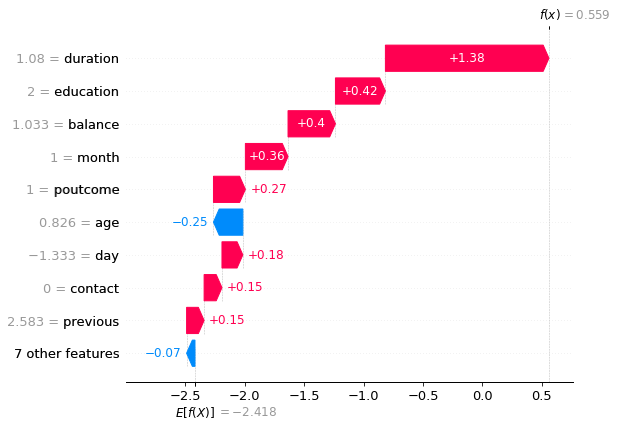

In [4]:
shap.plots.waterfall(shap_values[1])

#### Use beeswarm chart to get an overview of which features are most important for a model

This figure indicates that the most important feature is `duration`. Lhe long call duration has a strong impact on the positive prediction by the model.

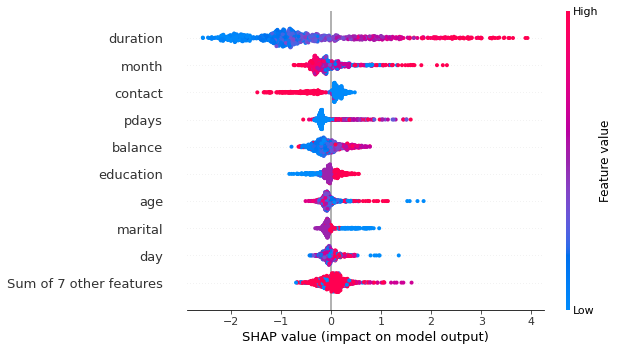

In [5]:
shap.plots.beeswarm(shap_values)

### Understand the interaction effects between 2 features using dependence scatter 

Customers with long talk time and small interval between campaigns are more likely to succeed in marketing

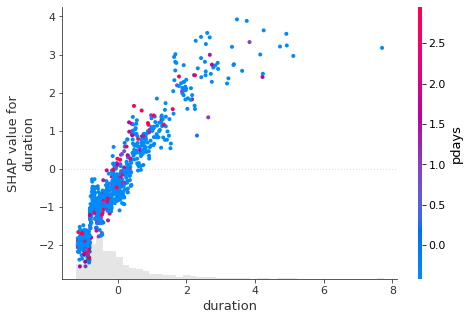

In [6]:
shap.plots.scatter(shap_values[:, "duration"], color=shap_values[:, "pdays"], show=True)